# Set up

In [56]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import requests
from footbot.data.utils import update_return_dict

# Getting data

In [ ]:
entry_history_arr = []

for i in np.random.choice(range(1, 3000000), 1000000, replace=False):
    try:
        entry_history_request = requests.get(f'https://fantasy.premierleague.com/api/entry/{i}/history/')
        entry_history_data = entry_history_request.json()
        entry_history_data['entry'] = i
        entry_history_arr.append(entry_history_data)
    except Exception as e:
        continue

print(len(entry_history_arr))

In [23]:
entry_past_df = pd.DataFrame([
    dict([
        ('entry', i['entry'])        
    ] +
    [
        (j['season_name'] + '_total_points', j['total_points'])
        for j in i['past']
    ] +
    [
        (j['season_name'] + '_rank', j['rank'])
        for j in i['past']
    ])
    for i in entry_history_arr
])

entry_past_df.head()

,entry,2018/19_total_points,2018/19_rank,2011/12_total_points,2012/13_total_points,2013/14_total_points,2014/15_total_points,2015/16_total_points,2016/17_total_points,2017/18_total_points,...,2010/11_total_points,2010/11_rank,2008/09_total_points,2009/10_total_points,2008/09_rank,2009/10_rank,2006/07_total_points,2007/08_total_points,2006/07_rank,2007/08_rank
0,2694922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,240854,1645.0,4988634.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1672641,1834.0,3771687.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2615400,2087.0,955653.0,1708.0,2000.0,2133.0,1827.0,1889.0,1903.0,1872.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1855817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,383.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
top_entries = entry_past_df[
    (entry_past_df['2018/19_rank'] < 30000)
    & (entry_past_df['2017/18_rank'] < 30000)
    & (entry_past_df['2016/17_rank'] < 30000)
]['entry'].values

len(top_entries)

281

In [48]:
pd.Series(top_entries).to_csv('./top_entries.csv', index=False)

/home/tom/footbot/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [26]:
bootstrap_request = requests.get('https://fantasy.premierleague.com/api/bootstrap-static/')
bootstrap_data = bootstrap_request.json()

current_event = [i for i in bootstrap_data['events'] if i['is_current']][0]['id']
current_event

4

In [28]:
element_df = pd.DataFrame(
    bootstrap_data['elements']
)

element_df = element_df[['id', 'web_name']]
element_df.columns = ['element', 'web_name']

In [29]:
entry_season_arr = []

for i in top_entries:
    for j in range(1, current_event + 1):
        try:
            entry_season_request = requests.get(f'https://fantasy.premierleague.com/api/entry/{i}/event/{j}/picks/')
            entry_season_data = entry_season_request.json()
            entry_season_data['entry'] = i
            entry_season_data['event'] = j
            entry_season_arr.append(entry_season_data)
        except Exception as e:
            continue

print(len(entry_season_arr))

1124


In [65]:
picks_df = pd.DataFrame(
    [
        update_return_dict(j, ['entry', 'event'], [i['entry'], i['event']])
        for i in entry_season_arr for j in i['picks']
    ])

In [68]:
picks_df[
    [
        'entry',
        'event'
    ]
    + list(picks_df.columns)[:-2]
]

,entry,event,element,position,multiplier,is_captain,is_vice_captain
0,75733,1,47,1,1,False,False
1,75733,1,183,2,1,False,False
2,75733,1,141,3,1,False,False
3,75733,1,206,4,1,False,False
4,75733,1,265,5,1,False,False
...,...,...,...,...,...,...,...
16855,99574,4,278,11,1,False,False
16856,99574,4,48,12,0,False,False
16857,99574,4,128,13,0,False,False
16858,99574,4,234,14,0,False,False


In [71]:
def get_dict_keys(d, k):
    if not (isinstance, k, list):
        raise Exception
    arr = []
    for i in k:
        arr.append((i, d[i]))
    
    return dict(arr)

In [73]:
get_dict_keys({'a': 1, 'b': 2}, ['a'])

{'a': 1}

In [81]:
chips_df = pd.DataFrame([
    get_dict_keys(i, ['entry', 'event', 'active_chip'])
    for i in entry_season_arr
])

chips_df

,entry,event,active_chip
0,75733,1,None
1,75733,2,None
2,75733,3,None
3,75733,4,None
4,74662,1,None
...,...,...,...
1119,119606,4,None
1120,99574,1,None
1121,99574,2,None
1122,99574,3,None


In [30]:
current_event_arr = [i for i in entry_season_arr if i['event'] == current_event]

In [31]:
current_event_picks_df = pd.DataFrame([j for sl in [i['picks'] for i in current_event_arr] for j in sl])

current_event_picks_df['is_first_team'] = current_event_picks_df['position'].apply(lambda x: 1 if x <= 11 else 0)
current_event_picks_df['is_owned'] = 1

current_event_picks_df = current_event_picks_df.groupby('element', as_index=False).sum().round(2).join(
    element_df.set_index('element'), on='element'
).sort_values('is_owned', ascending=False)

current_event_picks_df = current_event_picks_df[
    ['element', 'web_name', 'is_owned', 'is_first_team', 'is_captain', 'is_vice_captain']]

# Analysing data

## Player selections

,element,web_name,is_owned,is_first_team,is_captain,is_vice_captain
66,214,Sterling,261,261,240.0,18.0
57,191,Salah,232,232,9.0,160.0
89,297,Lundstram,210,41,0.0,0.0
82,278,Pukki,209,209,0.0,12.0
37,141,Digne,199,199,0.0,1.0
...,...,...,...,...,...,...
90,307,Bednarek,1,1,0.0,0.0
34,131,Guaita,1,1,0.0,0.0
95,320,Redmond,1,0,0.0,0.0
124,414,Neves,1,1,0.0,0.0


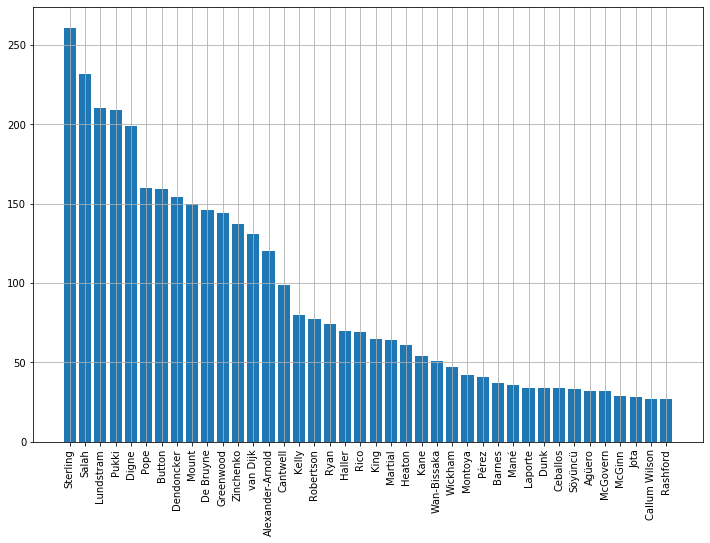

In [49]:
plt.figure(figsize=(12, 8))
plt.bar(
    current_event_picks_df['web_name'].iloc[:40],
    current_event_picks_df['is_owned'].iloc[:40],   
)
plt.xticks(rotation='vertical')
plt.grid()
plt.show()

## Wildcards

In [33]:
wildcard_df = pd.DataFrame(
    [dict([('event', i['event'])]) for i in entry_season_arr if i['active_chip'] == 'wildcard'])

(wildcard_df.groupby('event').size()/len(top_entries)).round(2)

event
2    0.01
3    0.15
4    0.12
dtype: float64

## Current performance

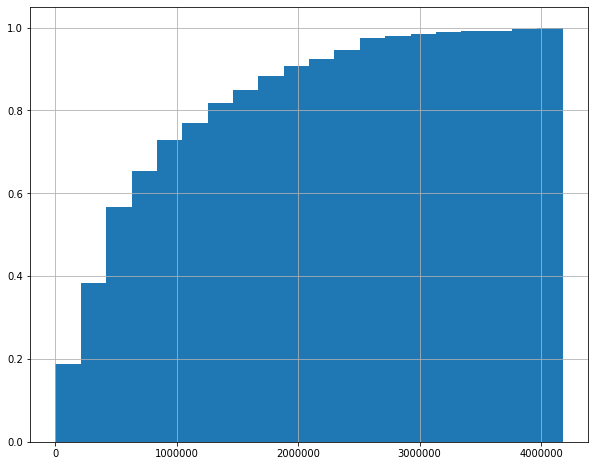

In [34]:
plt.figure(figsize=(10, 8))
plt.hist(
    pd.Series([i['entry_history']['overall_rank'] for i in current_event_arr]),
    bins=20,
    cumulative=True,
    density=True
)
plt.grid()
plt.show()

## Historic performance

In [35]:
hist_perf_df = entry_past_df[[
    'entry',
    '2018/19_rank',
    '2017/18_rank',
    '2016/17_rank'
]].dropna()

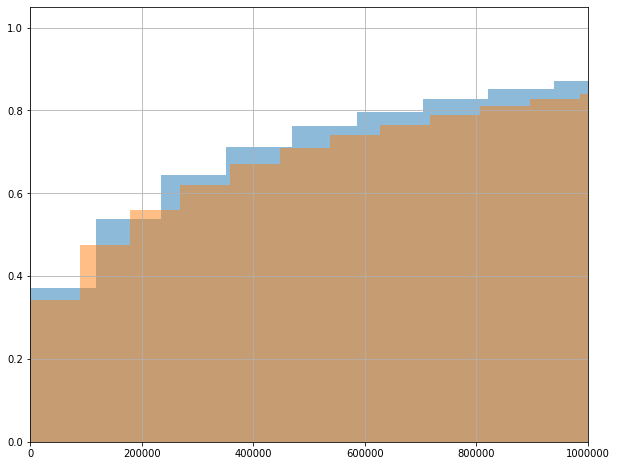

In [36]:
plt.figure(figsize=(10, 8))
plt.hist(
    hist_perf_df[hist_perf_df['2018/19_rank'] < 20000]['2017/18_rank'],
    bins=50,
    alpha=0.5,
    density=True,
    cumulative=True
)
plt.hist(
    hist_perf_df[hist_perf_df['2018/19_rank'] < 20000]['2016/17_rank'],
    bins=50,
    alpha=0.5,
    density=True,
    cumulative=True
)
plt.xlim(0, 1000000)
plt.grid()
plt.show()

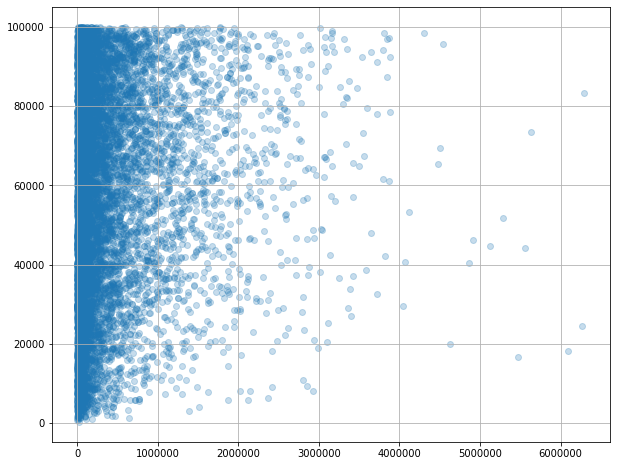

In [37]:
hist_perf_df['avg_rank'] = (hist_perf_df['2017/18_rank'] + hist_perf_df['2016/17_rank'])/2

plt.figure(figsize=(10, 8))
plt.scatter(
    hist_perf_df[hist_perf_df['avg_rank'] < 100000]['2018/19_rank'],
    hist_perf_df[hist_perf_df['avg_rank'] < 100000]['avg_rank'],
    alpha=0.25
)
plt.grid()
plt.show()

In [38]:
np.corrcoef(
    hist_perf_df[hist_perf_df['avg_rank'] < 100000]['2018/19_rank'],
    hist_perf_df[hist_perf_df['avg_rank'] < 100000]['avg_rank']
)

array([[1.       , 0.1400505],
       [0.1400505, 1.       ]])